In [10]:
from __future__ import division
import numpy as np
import scipy as sc
from itertools import product
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import PIL
from numpy import log10
import random
from math import factorial
from scipy.stats import linregress, gaussian_kde
from scipy import stats
from scipy.spatial import distance
import warnings
import pandas as pd
import re
import os
import math
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm
from scipy.optimize import linear_sum_assignment
import colorsys
from collections import Counter
import scipy.optimize as opt
import scipy.special as sp
import ot
import timeit

warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

pd.set_option('display.max_columns', None)


In [11]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import mode

import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import mode

def compute_shift_components(data, L=None, U=None, C=None, center='mean'):
    """
    Compute mass-based shift (Sm), positional shift (Sp), and hybrid shift (Sh).

    Parameters:
    - data: array-like, the sample data.
    - L: float, optional, lower bound of interval. If None, uses min(data).
    - U: float, optional, upper bound of interval. If None, uses max(data).
    - C: float, optional, central tendency. If None, determined by `center`.
    - center: 'mean', 'median', or 'mode' (default: 'mean').

    Returns:
    - Sm: float, mass-based shift
    - Sp: float, positional shift
    - Sh: float, hybrid shift (average of Sm and Sp)
    """
    data = np.asarray(data)
    ecdf = ECDF(data)

    # Set defaults
    if L is None:
        L = np.min(data)
    if U is None:
        U = np.max(data)
    if L >= U:
        raise ValueError("Lower bound L must be less than upper bound U.")

    # Central tendency
    if C is None:
        if center == 'mean':
            C = np.mean(data)
        elif center == 'median':
            C = np.median(data)
        elif center == 'mode':
            C = mode(data, keepdims=False).mode
        else:
            raise ValueError("Invalid center method. Choose 'mean', 'median', or 'mode'.")

    # Clip C to [L, U]
    C = np.clip(C, L, U)

    # Mass-based shift
    F_L = ecdf(L)
    F_C = ecdf(C)
    F_U = ecdf(U)
    mass_total = F_U - F_L
    mass_upper = F_U - F_C
    Sm = mass_upper / mass_total if mass_total > 0 else 0

    # Positional shift
    Sp = (U - C) / (U - L) if (U - L) > 0 else 0

    # Hybrid shift
    Sh = (Sm + Sp) / 2

    return Sm, Sp, Sh



#          

# Triangle inequality

In [12]:
# Given values for S1, S2, S3
S1 = 0
S2 = 1
S3 = 1

# Calculate absolute differences for RDS
RDS_12 = abs(S1 - S2)
RDS_23 = abs(S2 - S3)
RDS_13 = abs(S1 - S3)

# Check if the triangle inequality holds
LHS = RDS_12 + RDS_23  # Left-hand side of triangle inequality
RHS = RDS_13  # Right-hand side of triangle inequality

# Output results
print("LHS (|S1 - S2| + |S2 - S3|):", LHS)
print("RHS (|S1 - S3|):", RHS)
print("Does the triangle inequality hold?", LHS >= RHS)


LHS (|S1 - S2| + |S2 - S3|): 1
RHS (|S1 - S3|): 1
Does the triangle inequality hold? True


In [13]:
# Earth Mover's Distance (Wasserstein Distance)
def emd_distance(pdf1, pdf2, X1, X2):
    # Normalize PDFs to ensure they sum to 1 exactly.
    sum_pdf1 = np.sum(pdf1)
    sum_pdf2 = np.sum(pdf2)
    
    if sum_pdf1 == 0 or sum_pdf2 == 0:
        raise ValueError("One of the PDFs sums to zero.")
        
    pdf1 = pdf1 / sum_pdf1
    pdf2 = pdf2 / sum_pdf2

    # Replace any NaN values (if any) with zeros.
    pdf1 = np.nan_to_num(pdf1, nan=0.0)
    pdf2 = np.nan_to_num(pdf2, nan=0.0)
    
    # Compute the cost matrix: pairwise absolute differences between points.
    cost_matrix = np.abs(X1[:, None] - X2)  # Shape: (len(X1), len(X2))
    
    # Compute the Earth Mover's Distance (Wasserstein distance).
    emd = ot.emd2(pdf1, pdf2, cost_matrix)
    return emd


# Hellinger Distance
def hellinger_distance(pdf1, pdf2, X1):
    # Hellinger distance calculation
    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(pdf1) - np.sqrt(pdf2))**2) * (X1[1] - X1[0]))
    return hellinger



# Total Variation Distance (TVD)
def tvd_distance(cdf1, cdf2):
    # Total Variation Distance is the maximum of the absolute difference of CDFs
    tvd = np.max(np.abs(cdf1 - cdf2))
    return tvd



# Kolmogorov-Smirnov (KS) Distance
def ks_distance(X1, X2):
    # Use the Kolmogorov-Smirnov test from scipy to get the KS distance
    ks_statistic, _ = ks_2samp(X1, X2)
    return ks_statistic


def energy_distance(pdf1, pdf2, X):
    dx = X[1] - X[0]
    
    # Pairwise distance computation
    energy = 2 * np.sum(np.outer(pdf1, pdf2) * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    energy = energy - np.sum(pdf1[:, None] * pdf1 * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    energy = energy - np.sum(pdf2[:, None] * pdf2 * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    
    return energy


def cramer_von_mises_distance(cdf1, cdf2, X):
    dx = X[1] - X[0]
    
    # Cramér–von Mises distance
    cvm = np.sum((cdf1 - cdf2)**2) * dx
    
    return cvm



In [18]:
import numpy as np
from scipy.stats import beta, ks_2samp
import ot

DS_ls = []
wd_ls = []
emd_ls = []
hld_ls = []
tvd_ls = []
ksd_ls = []
end_ls = []
cvd_ls = []

a1_ls = []
a2_ls = []
b1_ls = []
b2_ls = []

for i in range(1000):
    # Increase number of points to avoid under-sampling
    X_range = np.linspace(0.001, 0.999, 1000)  # Avoiding 0 and 1
    
    # Randomly generate Beta parameters
    a1 = 10**np.random.uniform(-1, 1)
    a2 = 10**np.random.uniform(-1, 1)
    b1 = 10**np.random.uniform(-1, 1)
    b2 = 10**np.random.uniform(-1, 1)

    # Compute PDFs
    pdf1 = beta.pdf(X_range, a1, b1)
    pdf2 = beta.pdf(X_range, a2, b2)

    # Ensure PDFs are valid (no NaNs, no zero-sum issues)
    if np.any(np.isnan(pdf1)) or np.any(np.isnan(pdf2)) or np.sum(pdf1) == 0 or np.sum(pdf2) == 0:
        print(f"Skipping iteration {i} due to invalid PDF values.")
        continue
    
    pdf1 /= np.sum(pdf1)  # Normalize
    pdf2 /= np.sum(pdf2)

    # Compute CDFs for TVD
    cdf1 = beta.cdf(X_range, a1, b1)
    cdf2 = beta.cdf(X_range, a2, b2)

    # Compute distances
    #emd = emd_distance(pdf1.copy(), pdf2.copy(), X_range, X_range)
    hld = hellinger_distance(pdf1, pdf2, X_range)
    tvd = tvd_distance(cdf1, cdf2)
    cvd = cramer_von_mises_distance(cdf1, cdf2, X_range)
    
    sample1 = beta.rvs(a1, b1, size=10000)  # Sample from first Beta
    sample2 = beta.rvs(a2, b2, size=10000)  # Sample from second Beta
    ksd = ks_2samp(sample1, sample2).statistic
    
    end = stats.energy_distance(sample1, sample2)
    wd = stats.wasserstein_distance(sample1, sample2)
    
    # Compute DS
    # mean, i.e., expected value of beta dist = a/(a+b)
    # since max = 1 and min = 0
    # s = (1 - mean)/(1 - 0)
    #   = 1 - mean
    
    #m1 = a1 / (a1 + b1)
    #m2 = a2 / (a2 + b2)
    #s1 = 1 - m1
    #s2 = 1 - m2
    
    
    #s1 = compute_Sm(sample1, L=np.min(sample1), U=np.max(sample1), C=np.mean(sample1))
    #s2 = compute_Sm(sample2, L=np.min(sample2), U=np.max(sample2), C=np.mean(sample2))
    
    
    Sm1, Sp1, Sh1 = compute_shift_components(sample1, L=0, U=1, C=np.mean(sample1))
    Sm2, Sp2, Sh2 = compute_shift_components(sample2, L=0, U=1, C=np.mean(sample2))
    #data, L=None, U=None, C=None, center='mean'
    
    ds = Sm1 - Sm2
    
    # Store results
    DS_ls.append(ds)
    wd_ls.append(wd)
    #emd_ls.append(emd)
    hld_ls.append(hld)
    tvd_ls.append(tvd)
    ksd_ls.append(ksd)
    end_ls.append(end)
    cvd_ls.append(cvd)

    a1_ls.append(a1)
    a2_ls.append(a2)
    b1_ls.append(b1)
    b2_ls.append(b2)


Energy Distance 0.34708603735539734
Wasserstein Distance 0.4878146377526586
Cramér–von Mises
Distance 0.25625984191352325
Hellinger Distance  12.581551900299019
Total Variation
Distance  0.4189982415229231
Kolmogorov-Smirnov
distance 0.42041864627404796


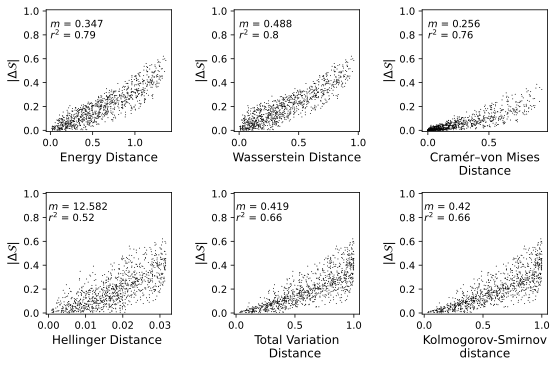

In [20]:

X_lists = [end_ls, 
           wd_ls, 
           cvd_ls,
           hld_ls, 
           tvd_ls, 
           ksd_ls,
          ]


x_labs = ['Energy Distance', 
          'Wasserstein Distance',
          'Cramér–von Mises\nDistance',
          'Hellinger Distance ',
          'Total Variation\nDistance ',
          'Kolmogorov-Smirnov\ndistance',
          ]

fig, axes = plt.subplots(2, 3, figsize=(9, 5.5))  # Create 2x3 subplots

v = 0.0
text_x_vals = [v, v, v, 
               v, v, v]

v = 0.77
text_y_vals = [v, v, v, 
               v, v, v]


for i, x_ls in enumerate(X_lists):
    
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    
    ylab = r'$|\Delta\mathcal{S}|$'
    y_ls = np.abs(DS_ls)
    
    if i == 2:
        y_ls = y_ls**2
        ylab = r'$|\Delta\mathcal{S}|$'
    
    ax.scatter(x_ls, y_ls, facecolors='k', s = 1, 
            #edgecolors=None, 
            linewidths=0.0,
            )
    
    
    # Add labels and title
    ax.set_xlabel(x_labs[i], fontsize=12)
    ax.set_ylabel(ylab, fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    
    slope, intercept, r_val, p_val, std_err = linregress(x_ls, y_ls)
    fitted_vals = slope * np.array(x_ls) + intercept
    
    s = r'$m$ = ' + str(round(slope, 3)) + '\n' + r'$r^2$ = ' + str(round(r_val**2, 2))
    ax.text(text_x_vals[i], text_y_vals[i], s, fontsize=10)
    print(x_labs[i], slope)
    
    ax.set_ylim(-0.01, 1.01)
    
    
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.savefig('Final_Figs/manuscript/Fig2.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig2.pdf', bbox_inches='tight', format='pdf', dpi=600)

#plt.show()
#plt.close()